# Library Import

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import zipfile
import os
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, LSTM, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.saved_model.save import save
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from google.colab import drive

# Data Load

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/.shortcut-targets-by-id/1DMl8_gsMSQquDiXFHTNtt3VL4RdJuDk7/DATASET .

# Data Preprocessing

In [ ]:
train_dir = "/content/DATASET/TRAIN/"
test_dir = "/content/DATASET/TEST/"

In [ ]:
img_width = 224
img_height = 224
batch_size = 32
model_dir = "./model"
checkpoint = "model_checkpoint_best_.keras"
checkpoint_path = os.path.join(model_dir, checkpoint)

In [ ]:
os.makedirs(model_dir, exist_ok=True)

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle="True"
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 1424 images belonging to 26 classes.
Found 351 images belonging to 26 classes.
Found 208 images belonging to 26 classes.


In [ ]:
labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

In [ ]:
class_weights = dict(enumerate(class_weights))

In [ ]:
print(train_generator.class_indices)
print(train_generator.samples)

{'Aceh_Pintu_Aceh': 0, 'Bali_Barong': 1, 'Bali_Merak': 2, 'DKI_Ondel_Ondel': 3, 'Jawa_Barat_Megamendung': 4, 'Jawa_Tengah_Batik_Lasem': 5, 'Jawa_Timur_Pring': 6, 'Kalimantan_Barat_Insang': 7, 'Kalimantan_Dayak': 8, 'Lampung_Gajah': 9, 'Madura_Mataketeran': 10, 'Maluku_Pala': 11, 'NTB_Lumbung': 12, 'Palembang_Songket': 13, 'Papua_Asmat': 14, 'Papua_Cendrawasih': 15, 'Papua_Tifa': 16, 'Solo_Parang': 17, 'Solo_Sidoluhur': 18, 'Solo_Sogan': 19, 'Solo_Truntum': 20, 'Sulawesi_Selatan_Lontara': 21, 'Sumatera_Barat_Rumah_Minang': 22, 'Sumatera_Utara_Boraspati': 23, 'Yogyakarta_Kawung': 24, 'Yogyakarta_Sidomukti': 25}
1424


# Model Initialization

In [ ]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(img_width, img_height, 3)
)

# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(
    train_generator.num_classes,
    activation="softmax",
    kernel_regularizer=l2(1e-4),
)(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Freeze some of the deeper base model layers
for layer in base_model.layers[:120]:
    layer.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=5,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

for layer in base_model.layers[:120]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,390,333 (16.75 MB)

 Trainable params: 4,036,578 (15.40 MB)

 Non-trainable params: 353,755 (1.35 MB)

In [ ]:
# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    print("Checkpoint found. Loading model...")
    model = tf.keras.models.load_model(checkpoint_path)
else:
    print("No checkpoint found. Training model from scratch...")

No checkpoint found. Training model from scratch...


In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8),
    ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, save_weights_only=False, verbose=1),
]

# Model Training

In [ ]:
history = model.fit(
    train_generator,
    epochs=45,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.1665 - loss: 3.6964
Epoch 1: val_accuracy improved from -inf to 0.57550, saving model to ./model/model_checkpoint_best_.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.1681 - loss: 3.6857 - val_accuracy: 0.5755 - val_loss: 1.6730 - learning_rate: 0.0010
Epoch 2/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.4600 - loss: 1.7910
Epoch 2: val_accuracy improved from 0.57550 to 0.67521, saving model to ./model/model_checkpoint_best_.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 683ms/step - accuracy: 0.4610 - loss: 1.7894 - val_accuracy: 0.6752 - val_loss: 1.2043 - learning_rate: 0.0010
Epoch 3/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.6481 - loss: 1.1317
Epoch 3: val_accuracy improved from 0.67521 to 0.78917, saving model to ./model/model_checkpoint_best_.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 646ms/step - accuracy: 0.6479 - loss: 1.1321 - val_accuracy: 0.7892 - val_loss: 0.8751 - learning_rate: 0

In [ ]:
# Fine-tuning
fine_tune_at = 200  # Unfreeze layers from 200 onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_fine_tune = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.9697 - loss: 0.1782
Epoch 1: val_accuracy did not improve from 0.89174
45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9698 - loss: 0.1778 - val_accuracy: 0.8803 - val_loss: 0.5928 - learning_rate: 1.0000e-05
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9714 - loss: 0.1743
Epoch 2: val_accuracy did not improve from 0.89174
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 669ms/step - accuracy: 0.9714 - loss: 0.1739 - val_accuracy: 0.8746 - val_loss: 0.6128 - learning_rate: 1.0000e-05
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9708 - loss: 0.1284
Epoch 3: val_accuracy did not improve from 0.89174
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 803ms/step - accuracy: 0.9708 - loss: 0.1285 - val_accuracy: 0.8803 - val_loss: 0.6447 - learning_rate: 1.0000e-05
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9614 - loss: 0.1445
Epoch 4: val_accuracy did not improve from 0.89174
45/45 ━━━━━━━━━━━

# Evaluation

In [ ]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss:.3f}, Validation Accuracy: {validation_accuracy:.2%}")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2%}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 623ms/step - accuracy: 0.8940 - loss: 0.6208
Validation Loss: 0.552, Validation Accuracy: 90.03%
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 630ms/step - accuracy: 0.8971 - loss: 0.4307
Test Loss: 0.419, Test Accuracy: 90.87%


In [ ]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
                             precision    recall  f1-score   support

            Aceh_Pintu_Aceh       0.88      0.88      0.88         8
                Bali_Barong       0.67      1.00      0.80         8
                 Bali_Merak       0.83      0.62      0.71         8
            DKI_Ondel_Ondel       1.00      1.00      1.00         8
     Jawa_Barat_Megamendung       1.00      1.00      1.00         8
    Jawa_Tengah_Batik_Lasem       1.00      0.50      0.67         8
           Jawa_Timur_Pring       1.00      0.88      0.93         8
    Kalimantan_Barat_Insang       0.88      0.88      0.88         8
           Kalimantan_Dayak       1.00      1.00      1.00         8
              Lampung_Gajah       0.89      1.00      0.94         8
         Madura_Mataketeran       1.00      1.00      1.00         8
                Maluku_Pala       1.00      1.00      1.00         8
                NTB_Lumbung       1.00      1.00      1.00       

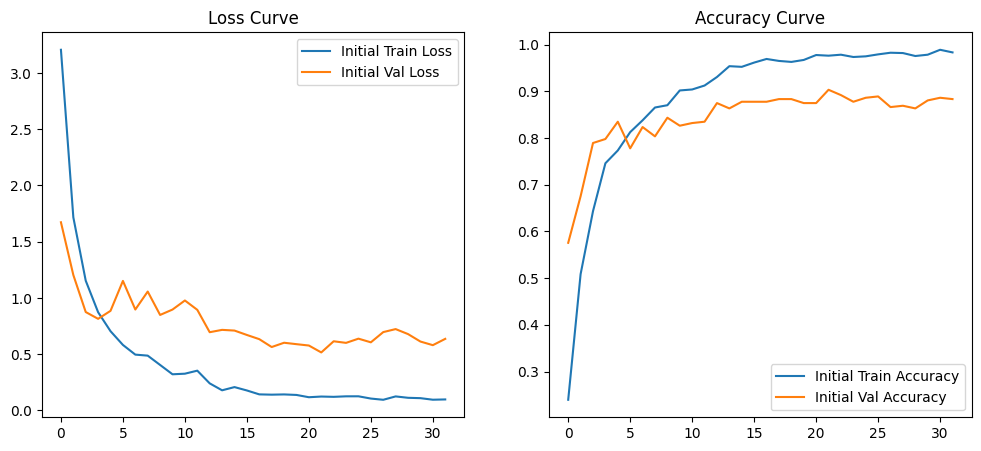

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Initial Train Loss")
plt.plot(history.history["val_loss"], label="Initial Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Initial Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Initial Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


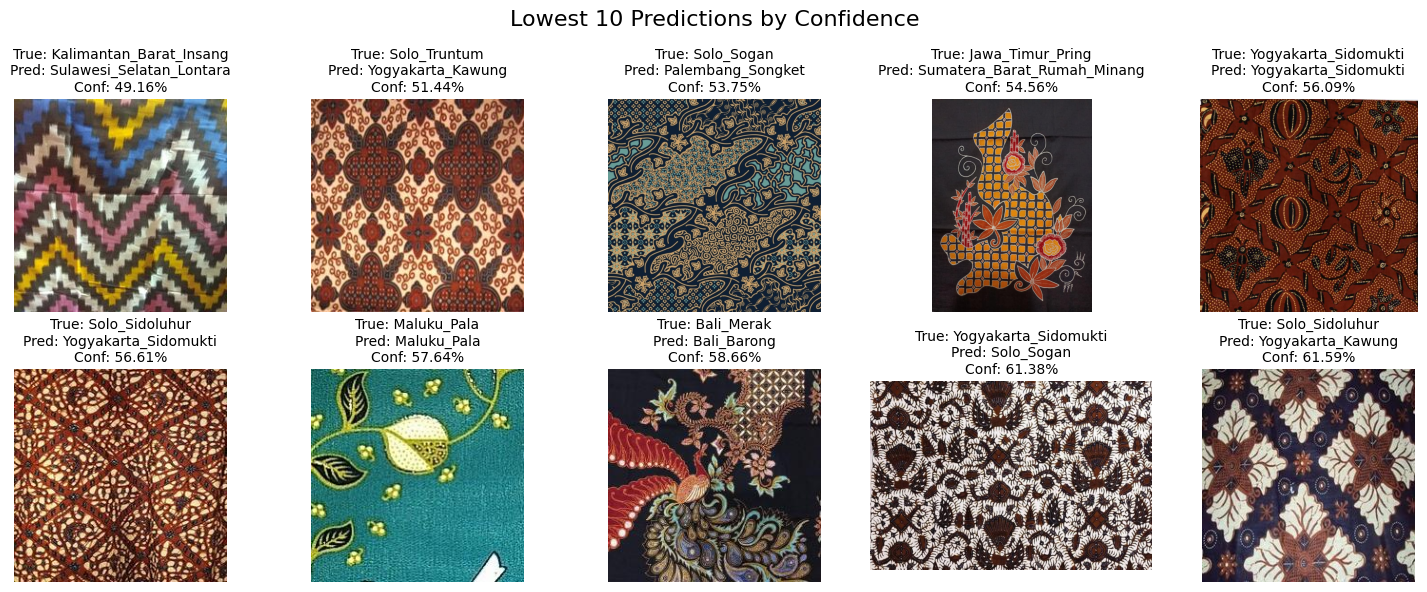

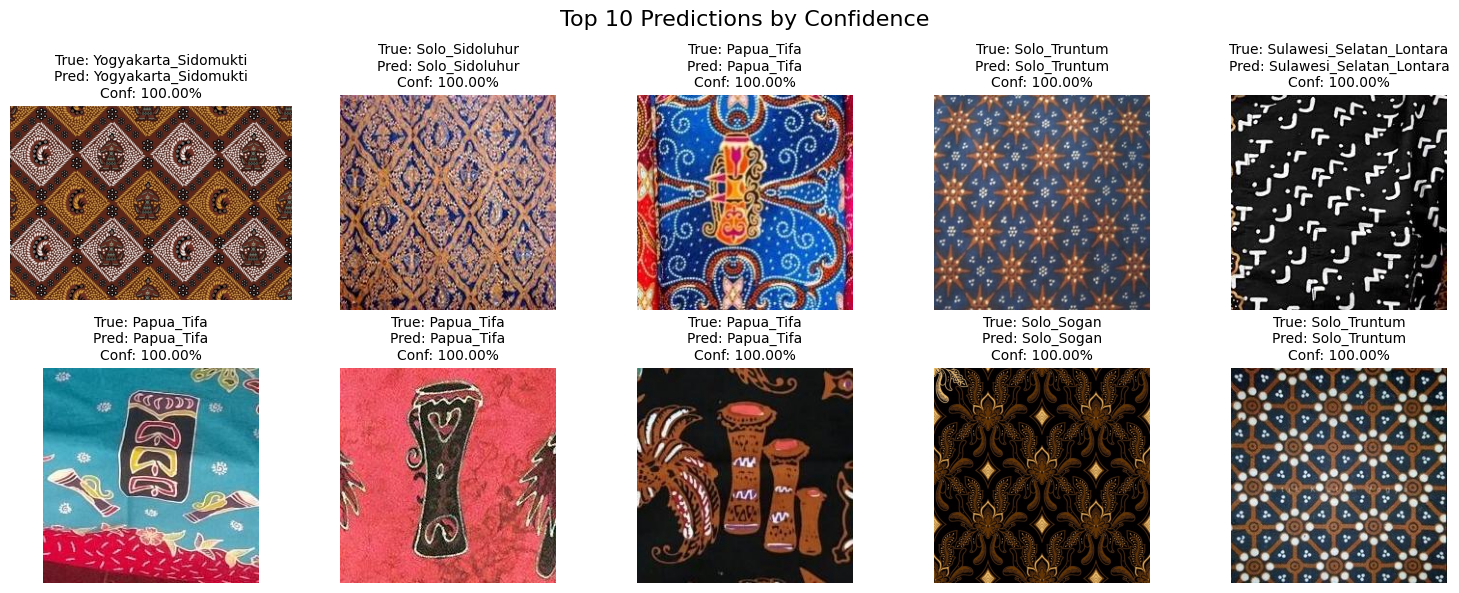

In [ ]:
predictions = model.predict(test_generator)
class_labels = list(test_generator.class_indices.keys())
true_indices = test_generator.classes
predicted_indices = np.argmax(predictions, axis=1)
prediction_confidences = np.max(predictions, axis=1)

# Visualization function
def visualize_predictions(indices, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, idx in enumerate(indices):
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)
        true_label = class_labels[true_indices[idx]]
        predicted_label = class_labels[predicted_indices[idx]]
        confidence = prediction_confidences[idx] * 100

        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}%", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Lowest and highest confidence predictions
low_conf_indices = np.argsort(prediction_confidences)[:10]
high_conf_indices = np.argsort(prediction_confidences)[-10:][::-1]

visualize_predictions(low_conf_indices, "Lowest 10 Predictions by Confidence")
visualize_predictions(high_conf_indices, "Top 10 Predictions by Confidence")

# Save Model

In [ ]:
saved_model_path = 'my_saved_model'
tfjs_output_dir = 'tfjs_graph_model'
if os.path.exists(saved_model_path):
    shutil.rmtree(saved_model_path)
    print(f"Removed existing SavedModel directory: {saved_model_path}")
if os.path.exists(tfjs_output_dir):
    shutil.rmtree(tfjs_output_dir)
    print(f"Removed existing TF.js output directory: {tfjs_output_dir}")

In [ ]:
print(f"Saving model to SavedModel format at: {saved_model_path}...")
tf.saved_model.save(model, saved_model_path)
print("Model successfully saved as SavedModel.")

# Verify the contents of the SavedModel directory
print(f"\nContents of '{saved_model_path}':")
!ls -lh "{saved_model_path}"
!ls -lh "{saved_model_path}/variables"
!ls -lh "{saved_model_path}/assets"

Saving model to SavedModel format at: my_saved_model...
Model successfully saved as SavedModel.

Contents of 'my_saved_model':
total 2.0M
drwxr-xr-x 2 root root 4.0K May 31 01:19 assets
-rw-r--r-- 1 root root   56 May 31 01:19 fingerprint.pb
-rw-r--r-- 1 root root 2.0M May 31 01:19 saved_model.pb
drwxr-xr-x 2 root root 4.0K May 31 01:19 variables
total 33M
-rw-r--r-- 1 root root 33M May 31 01:19 variables.data-00000-of-00001
-rw-r--r-- 1 root root 27K May 31 01:19 variables.index
total 0


In [ ]:
print(f"Converting SavedModel to TF.js Graph Model at: {tfjs_output_dir}...")
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    "my_saved_model" \
    "{tfjs_output_dir}"

Converting SavedModel to TF.js Graph Model at: tfjs_graph_model...
2025-05-31 01:20:51.202841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748654451.364317   11678 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748654451.420535   11678 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-31 01:21:03.037706: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748654463.037948   116

In [ ]:
tfjs_output_dir = 'tfjs_graph_model' # Assuming this is your output directory
print(f"\nVerifying contents of '{tfjs_output_dir}':")
!ls -lh "{tfjs_output_dir}"


Verifying contents of 'tfjs_graph_model':
total 17M
-rw-r--r-- 1 root root 4.0M May 31 01:21 group1-shard1of5.bin
-rw-r--r-- 1 root root 4.0M May 31 01:21 group1-shard2of5.bin
-rw-r--r-- 1 root root 4.0M May 31 01:21 group1-shard3of5.bin
-rw-r--r-- 1 root root 4.0M May 31 01:21 group1-shard4of5.bin
-rw-r--r-- 1 root root 544K May 31 01:21 group1-shard5of5.bin
-rw-r--r-- 1 root root 261K May 31 01:21 model.json


In [ ]:
!pip install --upgrade tensorflowjs

In [ ]:
!pip show tensorflowjs
print(f"TensorFlow version: {tf.__version__}")

Name: tensorflowjs
Version: 4.22.0
Summary: 
Home-page: https://js.tensorflow.org/
Author: Google LLC
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: flax, importlib_resources, jax, jaxlib, packaging, six, tensorflow, tensorflow-decision-forests, tensorflow-hub, tf-keras
Required-by: 
TensorFlow version: 2.18.0


In [ ]:
reloaded_tf_model = tf.saved_model.load(saved_model_path)

In [ ]:
!pip install tfjs-graph-converter

In [ ]:
from tfjs_graph_converter.api import load_graph_model, graph_to_function_v2
try:
    # load_graph_model loads the graph definition and weights
    tfjs_graph = load_graph_model('tfjs_graph_model')
    print("TF.js Graph Model loaded successfully.")

    # --- Extract the input name from the loaded graph's input list ---
    # The 'inputs' attribute of the tfjs_graph object is a list of input tensors.
    # For a single-input model, the first item in this list will be your input.
    if tfjs_graph.inputs:
        graph_input_name = tfjs_graph.inputs[0].name
        print(f"Found input name for graph model: '{graph_input_name}'")
    else:
        raise ValueError("No input tensors found in the TF.js Graph Model.")

    # Convert the loaded graph into a callable TensorFlow function
    tf_function_model = graph_to_function_v2(tfjs_graph)
    print("Converted TF.js Graph to TensorFlow Function (for inference).")

except Exception as e:
    print(f"Error loading TF.js model in Python: {e}")
    print("Please ensure 'tfjs-graph-converter' is installed and the path is correct.")
    # Exit or handle the error if the model can't be loaded
    exit()

TF.js Graph Model loaded successfully.
Error loading TF.js model in Python: 'Graph' object has no attribute 'inputs'
Please ensure 'tfjs-graph-converter' is installed and the path is correct.


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import efficientnet

In [ ]:
def preprocess_image_for_inference(image_path):
    # Load and resize the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)  # NumPy array, float32, range [0, 255]
    img_array = efficientnet.preprocess_input(img_array)  # IMPORTANT: For EfficientNetB0, this is a pass-through
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (CORRECTED: axis=0)
    return img_array

In [ ]:
image_path = "images.jpeg"  # Replace with the path to your test image
input_tensor_np = preprocess_image_for_inference(image_path)

input_tensor_tf = tf.convert_to_tensor(input_tensor_np)
# --- Perform inference ---
print(f"\nPerforming inference with input shape: {input_tensor_tf.shape}, dtype: {input_tensor_tf.dtype}...")
predictions = tf_function_model(input_tensor_tf)

print("Inference successful. Predictions:")
print(predictions.numpy())  # Convert output tensor to numpy array

# If your model has a softmax output, you can get the predicted class
predicted_class_index = np.argmax(predictions.numpy())
print(f"Predicted class index: {predicted_class_index}")


Performing inference with input shape: (1, 224, 224, 3), dtype: <dtype: 'float32'>...


InvalidArgumentError: Graph execution error:

Detected at node StatefulPartitionedCall/functional_1/stem_bn_1/batchnorm/add_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-51-a0042d9f7088>", line 9, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/tfjs_graph_converter/api.py", line 420, in graph_to_function_v2

Detected at node StatefulPartitionedCall/functional_1/stem_bn_1/batchnorm/add_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-51-a0042d9f7088>", line 9, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/tfjs_graph_converter/api.py", line 420, in graph_to_function_v2

2 root error(s) found.
  (0) INVALID_ARGUMENT:  bias must be 1-dimensional[1,1,1,32]
	 [[{{node StatefulPartitionedCall/functional_1/stem_bn_1/batchnorm/add_1}}]]
	 [[StatefulPartitionedCall/functional_1/block6d_se_reduce_1/BiasAdd/_218]]
  (1) INVALID_ARGUMENT:  bias must be 1-dimensional[1,1,1,32]
	 [[{{node StatefulPartitionedCall/functional_1/stem_bn_1/batchnorm/add_1}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_pruned_106303]

In [ ]:
!zip -r saved_model.zip my_saved_model/

  adding: my_saved_model/ (stored 0%)
  adding: my_saved_model/assets/ (stored 0%)
  adding: my_saved_model/fingerprint.pb (stored 0%)
  adding: my_saved_model/saved_model.pb (deflated 91%)
  adding: my_saved_model/variables/ (stored 0%)
  adding: my_saved_model/variables/variables.index (deflated 76%)
  adding: my_saved_model/variables/variables.data-00000-of-00001 (deflated 8%)


In [ ]:
!zip -r tfjs_graph_model.zip tfjs_graph_model/

  adding: tfjs_graph_model/ (stored 0%)
  adding: tfjs_graph_model/group1-shard5of5.bin (deflated 8%)
  adding: tfjs_graph_model/group1-shard1of5.bin (deflated 7%)
  adding: tfjs_graph_model/group1-shard2of5.bin (deflated 7%)
  adding: tfjs_graph_model/group1-shard3of5.bin (deflated 7%)
  adding: tfjs_graph_model/group1-shard4of5.bin (deflated 7%)
  adding: tfjs_graph_model/model.json (deflated 96%)


In [ ]:
!cp -r model/model_checkpoint_best_.keras /content/drive/MyDrive

In [ ]:
!cp -r saved_model.zip /content/drive/MyDrive

In [ ]:
!cp -r tfjs_graph_model.zip /content/drive/MyDrive